In [105]:
import PIL
import torchvision.transforms as transforms
import cv2
import math
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; import matplotlib.pylab as plt
import seaborn as sns
import pickle
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns; sns.set()
import itertools
from torchvision.models import resnet152
import torch
datas = ['mini_test', 'crop','euro', 'isic', 'chest']
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 15

In [ ]:
for idx in range(5):
    plt.imshow(x_support[idx].cpu().permute(1, 2, 0))
    plt.show()

## clustering measure between support samples

In [73]:
# 1 shot -> 당연히 0이 나옴...
C = 5
N = 1
df = pd.DataFrame(None, columns = datas, index = [i for i in range(10)])
for data in datas:
    path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_001shot_head_default/feature/{}_support.npy'
    for i in range(10):
        denom = [] # 분모
        numer = [] # 분자
        support = np.load(path.format(data, i))
        mu = support.mean(axis=0).mean(axis=0)
        mu_i_arr = support.mean(axis=1)
        for cls in range(C):  
            index = [N*i + cls for i in range(N)]
            in_class = support[index]
            mu_i = np.mean(in_class, axis = 0)
            denom.append(np.linalg.norm(mu-mu_i) ** 2)
            for sample_idx in range(N):
                sample = in_class[sample_idx]
                numer.append(np.linalg.norm(sample-mu_i) ** 2)
        #print("episode {}".format(i))
        cluster_measure = C * sum(numer) / (N * sum(denom))
        #print("cluster measure : {:.4f}".format(cluster_measure))
        df.loc[i, data] = cluster_measure
df

,mini_test,crop,euro,isic,chest
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0


In [106]:
# 5 shot
C = 5
N = 5
df = pd.DataFrame(None, columns = datas, index = [i for i in range(10)])
for data in datas:
    path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/feature/{}_support.npy'
    for i in range(10):
        denom = [] # 분모
        numer = [] # 분자
        support = np.load(path.format(data, i))
        mu = support.mean(axis=0)
        mu_i_arr = support.mean(axis=1)
        for cls in range(C):
            index = [N*i + cls for i in range(N)]
            in_class = support[index]
            mu_i = np.mean(in_class, axis = 0)
            denom.append(np.linalg.norm(mu-mu_i) ** 2)
            for sample_idx in range(N):
                sample = in_class[sample_idx]
                numer.append(np.linalg.norm(sample-mu_i) ** 2)
        #print("episode {}".format(i))
        cluster_measure = C * sum(numer) / (N * sum(denom))
        #print("cluster measure : {:.4f}".format(cluster_measure))
        df.loc[i, data] = cluster_measure
df.index = ["support_{}".format(i) for i in range(10)]
df

,mini_test,crop,euro,isic,chest
support_0,50.720161,34.236298,33.489166,22.829445,28.898595
support_1,38.625194,29.758449,32.416482,30.304404,33.631042
support_2,51.658319,30.760557,35.999479,25.423304,24.593645
support_3,36.109914,25.572603,31.922523,26.561776,20.170266
support_4,44.143757,30.058215,29.906265,24.265734,22.937267
support_5,48.972895,25.202279,28.805999,31.457153,23.681867
support_6,49.444114,28.728323,26.854872,28.043362,22.124514
support_7,50.452999,28.188479,32.68619,30.973114,27.22767
support_8,41.317279,27.841243,34.776592,29.878736,22.768228
support_9,40.360792,31.719244,33.107412,29.925272,23.344655


### performance와 비교

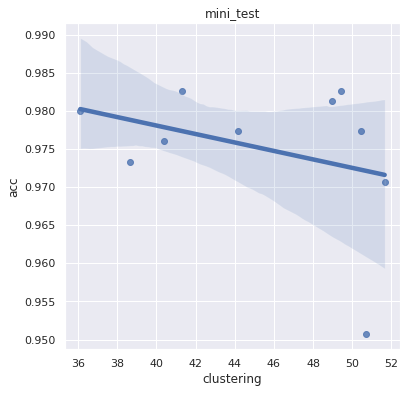

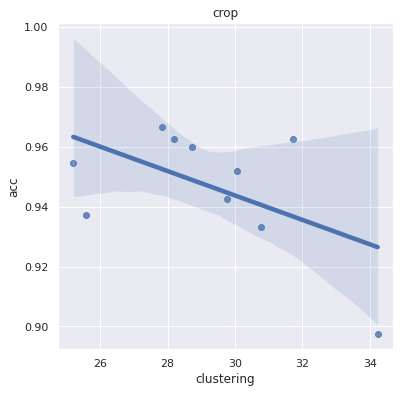

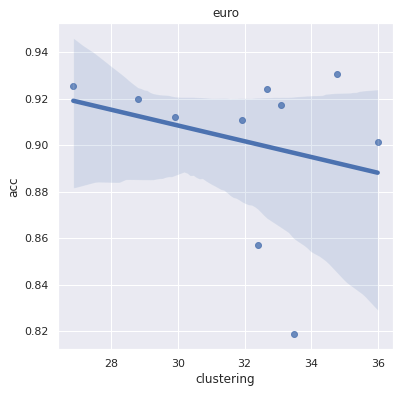

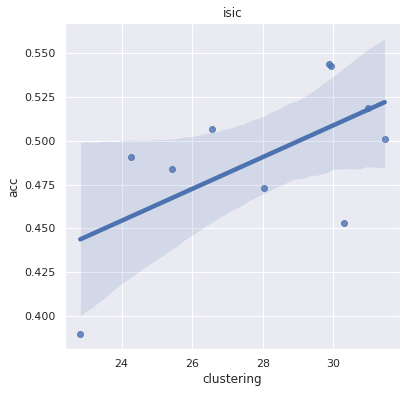

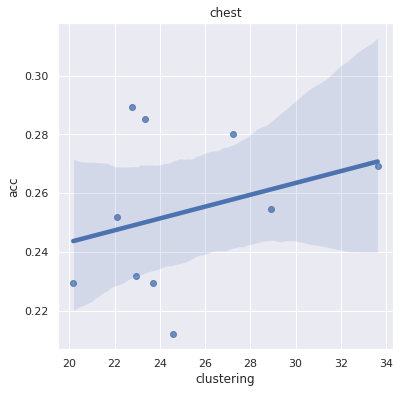

,mini_test,crop,euro,isic,chest
support_0,50.720161,34.236298,33.489166,22.829445,28.898595
support_1,38.625194,29.758449,32.416482,30.304404,33.631042
support_2,51.658319,30.760557,35.999479,25.423304,24.593645
support_3,36.109914,25.572603,31.922523,26.561776,20.170266
support_4,44.143757,30.058215,29.906265,24.265734,22.937267
support_5,48.972895,25.202279,28.805999,31.457153,23.681867
support_6,49.444114,28.728323,26.854872,28.043362,22.124514
support_7,50.452999,28.188479,32.68619,30.973114,27.22767
support_8,41.317279,27.841243,34.776592,29.878736,22.768228
support_9,40.360792,31.719244,33.107412,29.925272,23.344655


In [109]:
# 5 shot
# 각 support에 대해 query의 평균임
plt.rcParams["figure.figsize"] = (6, 6)
for data in datas:
    acc_path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/sq_test_acc.csv'
    test_acc = pd.read_csv(acc_path.format(data), index_col='Unnamed: 0')
    support_acc = test_acc.mean(axis=1)
    pair_df = pd.concat([df.loc[:,data].astype(float), support_acc], axis=1)
    pair_df.columns = ["clustering", "acc"]
    sns.regplot(x='clustering', y='acc', data=pair_df)
    plt.title(data)
    plt.show()
df

In [ ]:
for data in datas:
    acc_path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/sq_test_acc.csv'
    test_acc = pd.read_csv(acc_path.format(data), index_col='Unnamed: 0')
    support_acc = test_acc.mean(axis=1)
    pair_df = pd.concat([df.loc[:,data].astype(float), support_acc], axis=1)
    pair_df.columns = ["clustering", "acc"]
    sns.regplot(x='clustering', y='acc', data=pair_df)
    plt.title(data)
    plt.show()
df

#### 동일한 이미지인지 확인

In [176]:
for data in datas : 
    x_support_list = []
    x_query_list = []
    for i in range(10):
        path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_001shot_head_default/saved_0{}.txt'.format('crop', i)
        with open(path, 'rb') as f:
            test_acc = pickle.load(f)
            x_support = pickle.load(f)
            for img in x_support:
                x_support_list.append(img)
            y_support = pickle.load(f)
            x_query = pickle.load(f)
            for img in x_query:
                x_query_list.append(img)
    # check
    all_imgs_value = []
    all_imgs = x_support_list + x_query_list
    for img in all_imgs:
        all_imgs_value.append(img.sum().cpu().item())
    if len(all_imgs_value) == len(set(all_imgs_value)):
        print("[{}] : all imgs are different!".format(data))
    else:
        print("[{}] : there are the same img pair".format(data))

EOFError: Ran out of input

In [84]:
len(set(all_imgs_value))

751

In [ ]:
count={}
lists = all_imgs_value
for i in lists:
    try: count[i] += 1
    except: count[i]=1
print(count)

## Similarity between Support Samples

<AxesSubplot:>

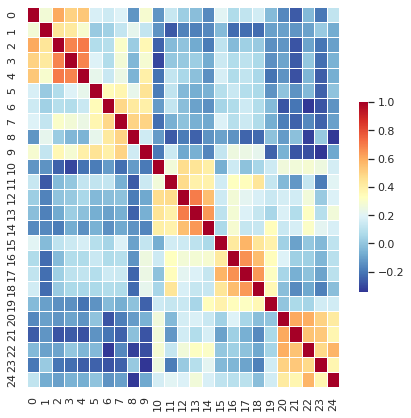

In [138]:
path = './logs/baseline/output/torch_resnet18_simclr_LS_default/mini_test/05way_005shot_head_default/feature/0_support.npy'
support = np.load(path)
fig, ax = plt.subplots( figsize=(7,7) )
# naive similarity btw all 25 samples
#support_all = support.swapaxes(0,1).reshape(25, 512)
sim = cosine_similarity(support, support)
sns.heatmap(sim, 
            cmap = 'RdYlBu_r', 
            #annot = True,   # 실제 값을 표시한다
            #mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = sim.min(), vmax = sim.max()   # 컬러바 범위 -1 ~ 1
           )  
# in-class similarity

## Hardness between Support and Query

In [99]:
def micro_forward(model, x, loss_func=None, loss_coef=None):
    yhs = []
    model.zero_grad()
    for x in torch.split(x, 75): # 크기 최대 75씩 자름, zip : (x,y)가 최대 75개 
        yh = model(x)
        yhs.append(yh)
    yh = torch.cat(yhs)
    return yh

def get_classifier(yh, y): # support_features, y_support

    classifier = torch.zeros((y.unique().size(0), yh.size(1)))
    for cls in torch.sort(y.unique())[0]:
        classifier[cls] = yh[y == cls].mean(dim=0)
    classifier = torch.nn.functional.normalize(classifier)
    return classifier

def get_hardness(x_support, y_support, x_query, y_query):
    with torch.no_grad():
        yhs_list = []
        # for feature in x_support: # 크기 최대 75씩 자름, zip : (x,y)가 최대 75개 
        #     yhs_list.append(torch.from_numpy(feature))
        support_features = torch.from_numpy(x_support)

        classifier = get_classifier(support_features, y_support)

        yhq_list = []
        # for feature in x_query: # 크기 최대 75씩 자름, zip : (x,y)가 최대 75개 
        #     yhq_list.append(torch.from_numpy(feature))
        query_features = torch.from_numpy(x_query) # z(x;theta) : logits of backbone
        query_features = torch.nn.functional.normalize(query_features) # l2 norm normalize = w_y


        query_features = query_features @ classifier.t() # z_y = w * phi(x)
        p = torch.softmax(query_features, dim=1) # p(.|x)
        p = p[torch.arange(0, y_query.size(0)), y_query] #p(y|x)
        hardness = ((1. - p) / p).log().mean().item()
    return hardness 

In [100]:
df = pd.DataFrame(None, columns = range(10), index = range(10))
path = './logs/baseline/output/torch_resnet18_simclr_LS_default/mini_test/05way_005shot_head_default/feature/{}_{}.npy'
for support_episode in range(10):
    for query_episode in range(10):
        x_support = np.load(path.format(support_episode,'support'))
        x_query = np.load(path.format(query_episode, 'query'))
        y_support = torch.arange(5).repeat_interleave(5)
        y_query = torch.arange(5).repeat_interleave(15)
        
        hardness = get_hardness(x_support, y_support, x_query, y_query)
        df.loc[support_episode, query_episode] = hardness

df

,0,1,2,3,4,5,6,7,8,9
0,0.788479,0.797765,0.815623,0.785649,0.794334,0.788435,0.802937,0.816024,0.788092,0.79791
1,0.803957,0.801349,0.829922,0.80853,0.807979,0.805499,0.81818,0.833552,0.793544,0.824151
2,0.801019,0.787843,0.823743,0.79381,0.791403,0.795237,0.795814,0.81595,0.798936,0.812265
3,0.773695,0.776768,0.799167,0.772676,0.787621,0.779968,0.782768,0.795805,0.772078,0.785938
4,0.806001,0.797687,0.824101,0.806396,0.808636,0.801507,0.814482,0.831304,0.792003,0.815811
5,0.794118,0.788201,0.808014,0.783556,0.79053,0.795848,0.81128,0.815316,0.780172,0.786456
6,0.793386,0.777815,0.815518,0.792011,0.797512,0.79159,0.804263,0.813369,0.7687,0.797029
7,0.803686,0.7956,0.82017,0.80614,0.805391,0.812836,0.805967,0.821145,0.800766,0.812841
8,0.791316,0.807898,0.832297,0.800507,0.809023,0.809749,0.808754,0.82637,0.7918,0.802323
9,0.810495,0.814428,0.832173,0.814393,0.822886,0.823545,0.820543,0.838257,0.808165,0.823786


In [110]:
math.log(0.25)

-1.3862943611198906

### Simplified Version

In [1]:
support = dict(images=[], classes=[])

In [2]:
support

{'images': [], 'classes': []}

In [4]:
{cls : 1 for cls in [1,2,3,4]}

{1: 1, 2: 1, 3: 1, 4: 1}

In [9]:
support['classes'] += ([2] * 3) 

In [10]:
support

{'images': [], 'classes': [1, 1, 1, 1, 2, 2, 2]}